# 01. Perfomance Metrics

by Jose Guillen, Guillermo Figueroa and Samuel Ortiz

## Dependencies

In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import matplotlib.pyplot as plt


## Evaluating a classification model
**Model evaluation metrics for Classification Algorithm are implemented in this Notebook**


1. Confusion Matrix
2. Metrics computed from a confusion matrix ( Classification Accuracy & Error, Sensitivity/Recall, Specificity, False Positive Rate, Precision, F1 Score)
3. ROC Curves and Area Under the Curve (AUC)


In [37]:
# Reading the dataset into Pandas DataFrame
col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
pima = pd.read_csv("data/diabetes.csv", header=None, names=col_names)

# Delete row 0
pima.drop(0, inplace=True)
pima.head()


,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
1,6,148,72,35,0,33.6,0.627,50,1
2,1,85,66,29,0,26.6,0.351,31,0
3,8,183,64,0,0,23.3,0.672,32,1
4,1,89,66,23,94,28.1,0.167,21,0
5,0,137,40,35,168,43.1,2.288,33,1


**Lets predict the diabetes status of a patient given their health measurements**

In [38]:
# Defining attributes and label
feature_cols = ['pregnant', 'insulin', 'bmi', 'age']
X = pima[feature_cols]
y = pima.label

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [39]:
# Make class predictions for the testing set
y_pred_class = logreg.predict(X_test)

In [40]:
# Comparing the true and predicted response values
print('True:', y_test.values[0:25])
print('Pred:', y_pred_class[0:25])

True: ['1' '0' '0' '1' '0' '0' '1' '1' '0' '0' '1' '1' '0' '0' '0' '0' '1' '0'
 '0' '0' '1' '1' '0' '0' '0']
Pred: ['0' '0' '0' '0' '0' '0' '0' '1' '0' '1' '0' '1' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0']


In [41]:
confusion = metrics.confusion_matrix(y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
confusion

array([[114,  16],
       [ 46,  16]])

**Basic terminology**

1. True Positives (TP): Correct prediction that they do have diabetes
2. True Negatives (TN): Correct prediction that they don't have diabetes
3. False Positives (FP): Incorrect prediction that they do have diabetes (a "Type I error")
4. False Negatives (FN): Incorrect prediction that they don't have diabetes (a "Type II error")

For any model, the type 1 and type 2 Error should be minimal and statistical power should be high to support our hypothesis. Analyzing these metrics viz. Confusion metrix therefore give us an estimate of the performance of our model.

**Metrics computed from a confusion matrix**

In [42]:
# Classification Accuracy

print("Classification Accuracy:", (TP + TN) / float(TP + TN + FP + FN))

Classification Accuracy: 0.6770833333333334


In [43]:
# Classification Error: Overall, how does the classifier predict incorrectly (Misclassification Rate)

print("Misclassification Rate: ",(FP + FN) / float(TP + TN + FP + FN))

Misclassification Rate:  0.3229166666666667


In [44]:
# Recall: When the actual value is positive, how often is the prediction correct?
recall = TP / float(TP + FN)
print("Recall:",TP / float(TP + FN))

Recall: 0.25806451612903225


In [45]:
# Specificity: When the actual value is negative, how often is the prediction correct?

print("Specificity",TN / float(TN + FP))


Specificity 0.8769230769230769


In [46]:
# Precision: When a positive value is predicted, how often is the prediction correct?
precision = TP / float(TP + FP)
print("Precision", TP / float(TP + FP))

Precision 0.5


In [47]:
# F1 Score

print("F1 Score:", (2 * (precision * recall) / (precision + recall)))

F1 Score: 0.3404255319148936


Confusion matrix gives a more complete picture of how the classifier is performing. Allows to compute various classification metrics, and these metrics can guide model selection. Useful for multi-class classification problem.


**ROC Curves and Area Under the Curve (AUC)**

Receiver Operating Characteristic curve is a plot of the true positive rate against the false positive rate affected by various thresholds values. It can be used to choose a threshold value that balances sensitivity and specificity depending on the business scenario.


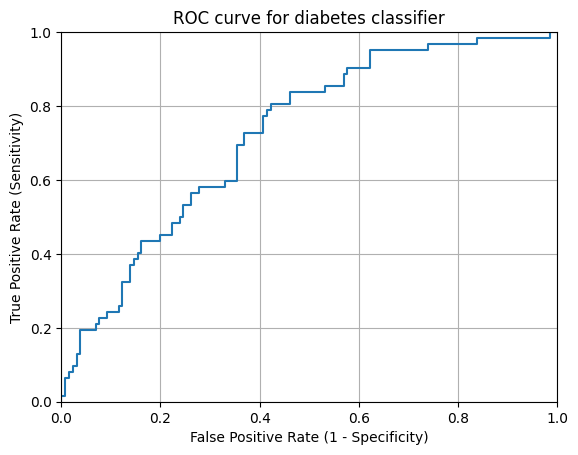

In [48]:
# Convertir y_test a enteros
y_test = y_test.astype(int)

# Ahora puedes ejecutar el código para la curva ROC sin problemas
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)



In [49]:
# Defining a function that accepts the threshold value and prints sensitivity and specificity
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [50]:
evaluate_threshold(0.5)

Sensitivity: 0.25806451612903225
Specificity: 0.8769230769230769


In [51]:
evaluate_threshold(0.8)

Sensitivity: 0.016129032258064516
Specificity: 0.9923076923076923


AUC is the percentage of the ROC plot that is underneath the curve. AUC is important in determining the classifier's performance and is a useful metrics in case of an high class imbalance dataset.

In [52]:
# IMPORTANT: First argument is true values, second argument is predicted probabilities
print("AUC Score:",metrics.roc_auc_score(y_test, y_pred_prob))

AUC Score: 0.7227047146401985


In [53]:
# calculate cross-validated AUC
print("Cross-Validated AUC Score:",cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean())

Cross-Validated AUC Score: 0.7425071225071225
